In [3]:
import torch
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
from skeleton import skeleton
import liftpose.legacy.utils as utils
import liftpose.legacy.stats as stats
G, color_edge = skeleton()

Load data and rescale

In [12]:
data_dir = 'out/'
template_dir = 'out/'
        
#load predictions
data = torch.load(data_dir + '/test_results.pth.tar')
out = data['output']
inp = data['input']

#output
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d']
test_keypts = torch.load(data_dir + '/stat_3d.pth.tar')['LR_test']
test_keypts = np.concatenate([v for k,v in test_keypts.items()], 0)
out_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
out_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
offset = torch.load(data_dir + '/stat_3d.pth.tar')['offset']
offset = np.concatenate([v for k,v in offset.items()], 0)
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d'] 
out = utils.add_roots(out,targets_1d,len(out_mean))
out = stats.unNormalize(out, out_mean, out_std)
out += np.hstack((offset[0,15:],offset[0,15:]))

out = utils.filter_data(out, window=3, order=2)

#inputs
targets_2d = torch.load(template_dir + '/stat_2d.pth.tar')['targets_2d']    
inp_mean = torch.load(template_dir + 'stat_2d.pth.tar')['mean']
inp_std = torch.load(template_dir + 'stat_2d.pth.tar')['std']
inp = utils.add_roots(inp,targets_2d,len(inp_mean))
inp = stats.unNormalize(inp, inp_mean, inp_std)

inp /= 112
out /= 212
poses = np.stack((inp[:,::2],inp[:,1::2],out), axis=2)

Projected traces

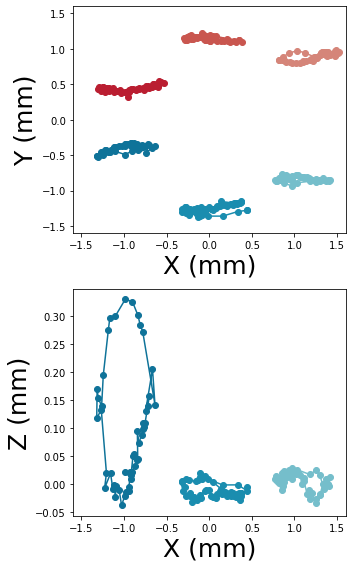

In [13]:
tint = [50,100]

fig = plt.figure(figsize=([5,8])) 
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

times = np.arange(tint[0],tint[1])

#plot projected tarsus coordinates
for i in [4,9,14,19,24,29]:
    ax1.plot(poses[times,i,0],poses[times,i,1],'-o', c=color_edge[i]) 
       
for j, i in enumerate([4,9,14]):
    ax2.plot(poses[times,i,0],poses[times,i,2]+0.05,'-o', c=color_edge[i])
        
ax1.set_xlabel('X (mm)', fontsize=25)
ax1.set_ylabel('Y (mm)', fontsize=25)
ax2.set_xlabel('X (mm)', fontsize=25)
ax2.set_ylabel('Z (mm)', fontsize=25)
ax1.set_xlim([-1.6, 1.6])
ax1.set_ylim([-1.6, 1.6])
ax2.set_xlim([-1.6, 1.6])
plt.tight_layout()
plt.savefig('Figure_3G.png')

# Video

Projected traces

100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


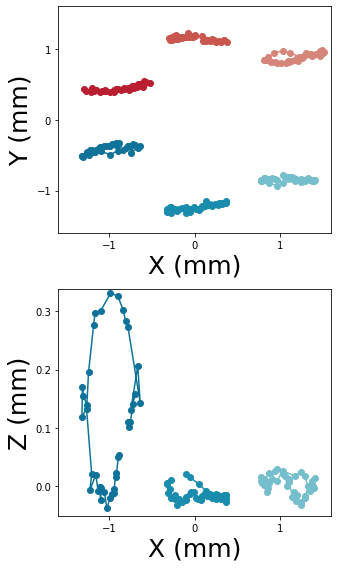

In [14]:
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm

nframes = 100
w = 40

fig = plt.figure(figsize=([5,8])) 
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

times = np.arange(0,w)

l = {}
count = 0
for i in [4,9,14,19,24,29]:
    l[count], = ax1.plot(poses[times,i,0], poses[times,i,1],'-o', color=color_edge[i]) 
    count+=1
       
for i in [4,9,14]: #plot projected tarsus coordinates
    l[count], = ax2.plot(poses[times,i,0], poses[times,i,2]+0.05,'-o', color=color_edge[i])
    count+=1

ax1.set_xlabel('X (mm)', fontsize=25)
ax1.set_ylabel('Y (mm)', fontsize=25)
ax2.set_xlabel('X (mm)', fontsize=25)
ax2.set_ylabel('Z (mm)', fontsize=25)
ax1.set_xlim([-1.6, 1.6])
ax1.set_ylim([-1.6, 1.6])
ax2.set_xlim([-1.6, 1.6])
plt.tight_layout()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "projected_traces_highres.mp4", 50):
    for t in tqdm(range(nframes)):
        
        if t-w<0:
            tint = [0, t]
        else:
            tint = [t-w, t]
            
        times = np.arange(tint[0], tint[1])
            
        count = 0
        for i in [4,9,14,19,24,29]:
            l[count].set_xdata(poses[times,i,0])
            l[count].set_ydata(poses[times,i,1])
            count+=1
            
        for j,i in enumerate([4,9,14]):
            l[count].set_xdata(poses[times,i,0])
            l[count].set_ydata(poses[times,i,2]+0.05)
            count+=1
              
        writer.grab_frame()

In [23]:
#!python fly_ventral_highres_make_video.py params.yaml
!ffmpeg -i cropped.mp4 -i LiftPose3D_prediction_fly_ventral_highres.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output.mp4
!ffmpeg -i output.mp4 -i projected_traces_highres.mp4 -filter_complex "[0:v]scale=-1:400[v0];[v0][1:v]hstack=inputs=2" output_2.mp4
!ffmpeg -i arena.mp4 -i output_2.mp4 -filter_complex "[0:v]scale=1050:-1,pad='iw+mod(iw\,2)':'ih+mod(ih\,2)'[v0];[v0][1:v]vstack=inputs=2" video_7.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma